# Machine learn spectra to classify sources
The approach here is similar to used for photometry, but some additional complication can be introduced because there's a lot more information. The models are therefore split into i) mutually exclusive single-label classification (e.g. star, disk), and ii) multi-label classification (e.g. PAH emission, ice absorption). These could probably be done simultaneously, but for simplicity and flexibilty we won't.

An additional classification could be done on subsets. For example, a spectrum that appears to be a star or Kuiper belt may also have a measureable spectral type, so a model could be trained on these. We don't want to be biased against finding emission/absorption in unexpected places, so these labels will be allowed to be found in any spectrum.

In [1]:
# so classifier can be changed externally
%load_ext autoreload
%autoreload 2

import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import sklearn.model_selection
import sklearn.metrics

# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, Flatten, Activation, Dropout
# import keras.optimizers, keras.regularizers
# from keras import backend as K
# import keras.utils

import sdf.spectrum
from classifier.spectra import *
from classifier.utils import *

%matplotlib notebook

# Single-label classification
Here we keep only labels that are mutually exclusive.

In [18]:
# get the data
skip = [ 'o-type','b-type','a-type','f-type','g-type','k-type','m-type','brown dwarf',
    'am sil em','cryst sil em','am sil abs','ice abs','gas abs','pah em','gas em','[nev]',
    'sl/ll offset']

spectra,sn,files,label_names,labels_onehot = get_data(label_skip=skip,sn_cut=5,norm=False,
                                                      median=cfg.median_classifying)

# and the corresponding wavelength array
_,_,wavelengths = read_spec(cfg.spectra+'training/'+files[0])

spec_len = spectra.shape[1]
nlabels = len(label_names)

nspec = spectra.shape[0]
for i in range(nlabels):
    print(np.sum(labels_onehot[:,i]),label_names[i])

Skipping cassis_yaaar_spcfw_20838656t.fits
Skipping cassis_yaaar_spcfw_4928768t.fits
Skipping cassis_yaaar_spcfw_16008960t.fits
Skipping cassis_yaaar_spcfw_16012288t.fits
Skipping cassis_yaaar_spcfw_21875712t.fits
Skipping cassis_yaaar_spcfw_22806016t.fits
Skipping cassis_yaaar_spcfw_18768128t.fits
Skipping cassis_yaaar_spcfw_18824704t.fits
Skipping cassis_yaaar_spcfw_18836992t.fits
Skipping cassis_yaaar_spcfw_20814336t.fits
Skipping cassis_yaaar_spcfw_20818432t.fits
Skipping cassis_yaaar_spcfw_20830464t.fits
82.0 class I
92.0 class II
25.0 transition
171.0 debris
169.0 star
12.0 be star


<IPython.core.display.Javascript object>


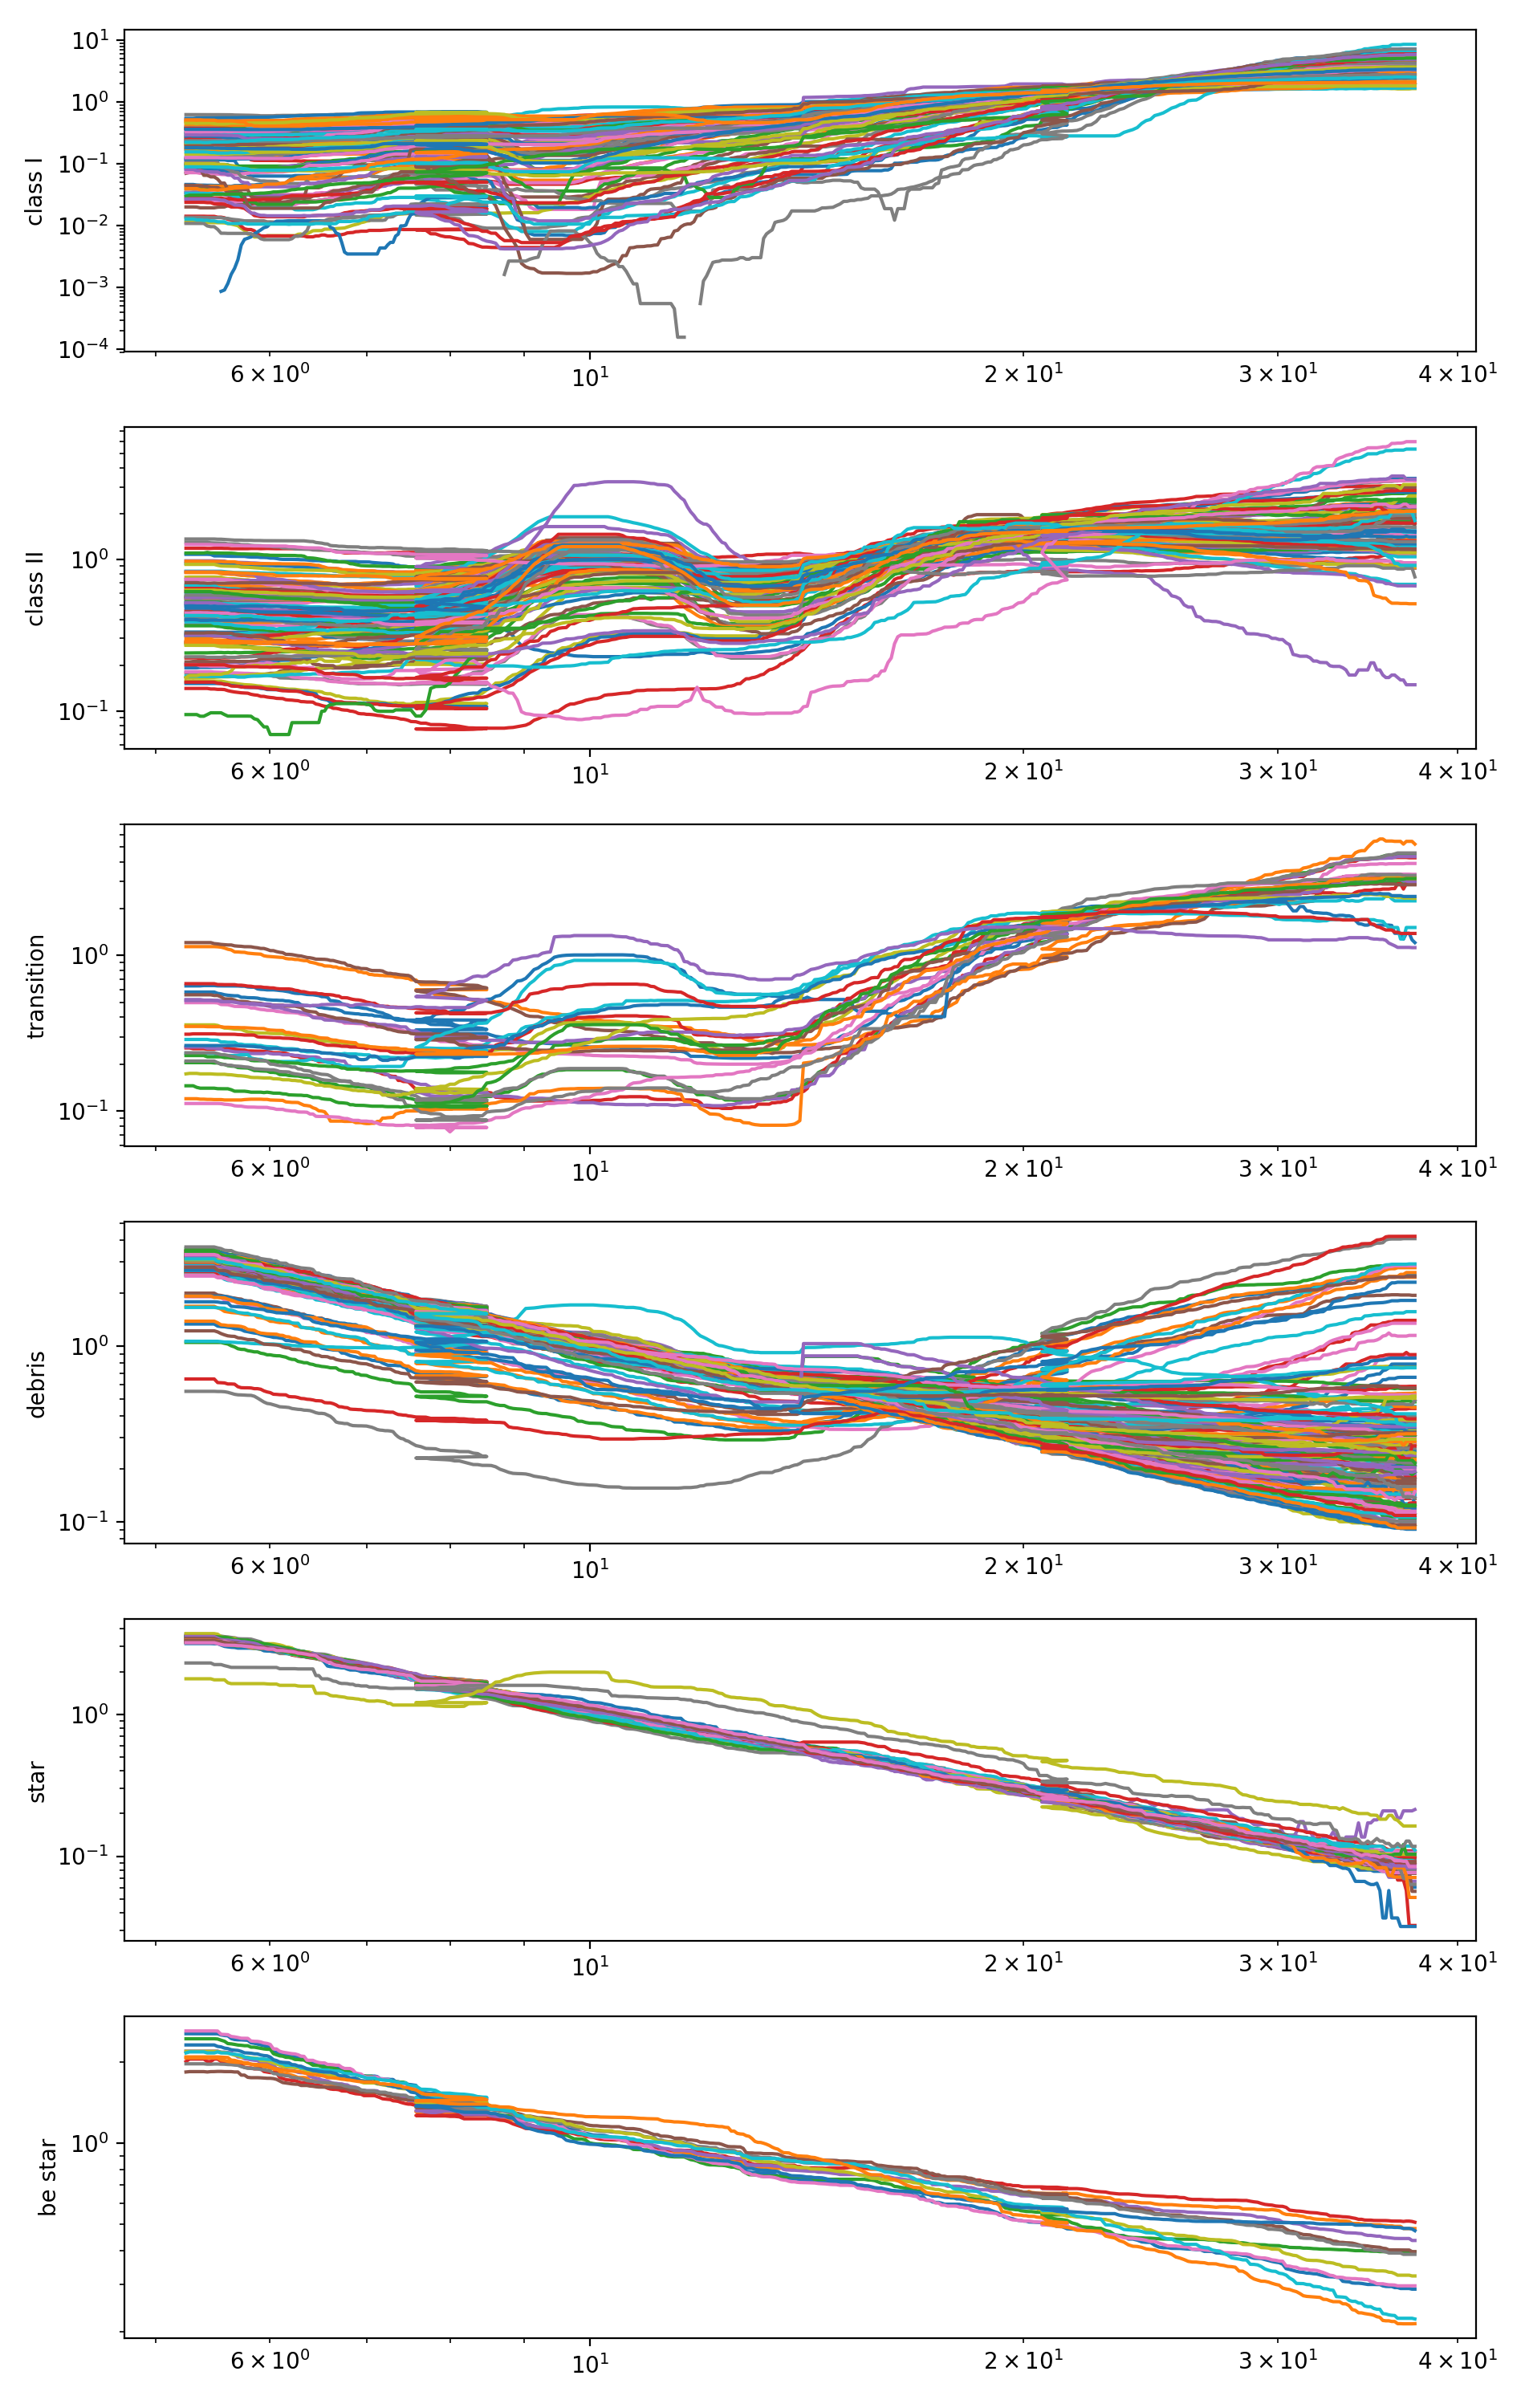

In [19]:
fig,ax = plt.subplots(nlabels,figsize=(9.5,15))
for i in range(nlabels):
    ok = labels_onehot[:,i] == 1
    l = ax[i].loglog(wavelengths,spectra[ok].T)
    ax[i].set_ylabel(label_names[i])
    
fig.tight_layout()

In [20]:
# augment the Be star sample with some combinations of the ones we have
cls = 5
ok = labels_onehot[:,cls] == 1
spectra,labels_onehot = augment_class(spectra,labels_onehot,cls,n_new=30)
# repeat, now also using the new ones we just created
cls = 5
ok = labels_onehot[:,cls] == 1
spectra,labels_onehot = augment_class(spectra,labels_onehot,cls,n_new=30)

# same for transition disks
cls = 2
ok = labels_onehot[:,cls] == 1
spectra,labels_onehot = augment_class(spectra,labels_onehot,cls,n_new=30)

nspec = spectra.shape[0]
for i in range(nlabels):
    print(np.sum(labels_onehot[:,i]),label_names[i])

82.0 class I
92.0 class II
55.0 transition
171.0 debris
169.0 star
72.0 be star


In [21]:
data_train,labels_train,data_test,labels_test = split_data(spectra,labels_onehot,train_fraction=0.6)
labels_train_nums = [np.argmax(r) for r in labels_train]
labels_test_nums = [np.argmax(r) for r in labels_test]

In [6]:
# this sets the defaults for things not varied in the grid search
if 1:
    clf = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(10,20,10),
                       tol=1e-6, warm_start=False, max_iter=10000,
                        learning_rate_init=0.001, learning_rate='adaptive')

    grid = [#{'solver':['adam'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
    #          'alpha':[1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
    #          {'solver':['sgd'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
    #           'alpha':[1e-6,1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
            {'solver':['lbfgs'], 'hidden_layer_sizes':[(100,200,100),(40,80,40),(10,20,10)],
             'alpha':[1e-4,1e-2],'learning_rate_init':[0.01,0.001]}]
    gs = sklearn.model_selection.GridSearchCV(clf,grid,cv=4)
    gs.fit(data_train,labels_train)

    print("Best parameters found on training set:")
    print(gs.best_params_)
    print()
    print("Grid scores on training set:")
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters found on training set:
{'alpha': 0.01, 'hidden_layer_sizes': (40, 80, 40), 'learning_rate_init': 0.01, 'solver': 'lbfgs'}

Grid scores on training set:
0.726 (+/-0.256) for {'alpha': 0.0001, 'hidden_layer_sizes': (100, 200, 100), 'learning_rate_init': 0.01, 'solver': 'lbfgs'}
0.726 (+/-0.273) for {'alpha': 0.0001, 'hidden_layer_sizes': (100, 200, 100), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.746 (+/-0.274) for {'alpha': 0.0001, 'hidden_layer_sizes': (40, 80, 40), 'learning_rate_init': 0.01, 'solver': 'lbfgs'}
0.751 (+/-0.271) for {'alpha': 0.0001, 'hidden_layer_sizes': (40, 80, 40), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.604 (+/-0.617) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate_init': 0.01, 'solver': 'lbfgs'}
0.715 (+/-0.258) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.759 (+/-0.266) for {'alpha': 0.01, 'hidden_layer_sizes': (100, 200, 100), 'learning_rate_

In [22]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(40,80,40),
                   tol=1e-6, warm_start=False, max_iter=50000,
                    learning_rate_init=0.001, learning_rate='adaptive')

clf.fit(data_train,labels_train_nums)
print('Step',clf.n_iter_,'loss',clf.loss_)

Step 2519 loss 0.00221109905558


<IPython.core.display.Javascript object>


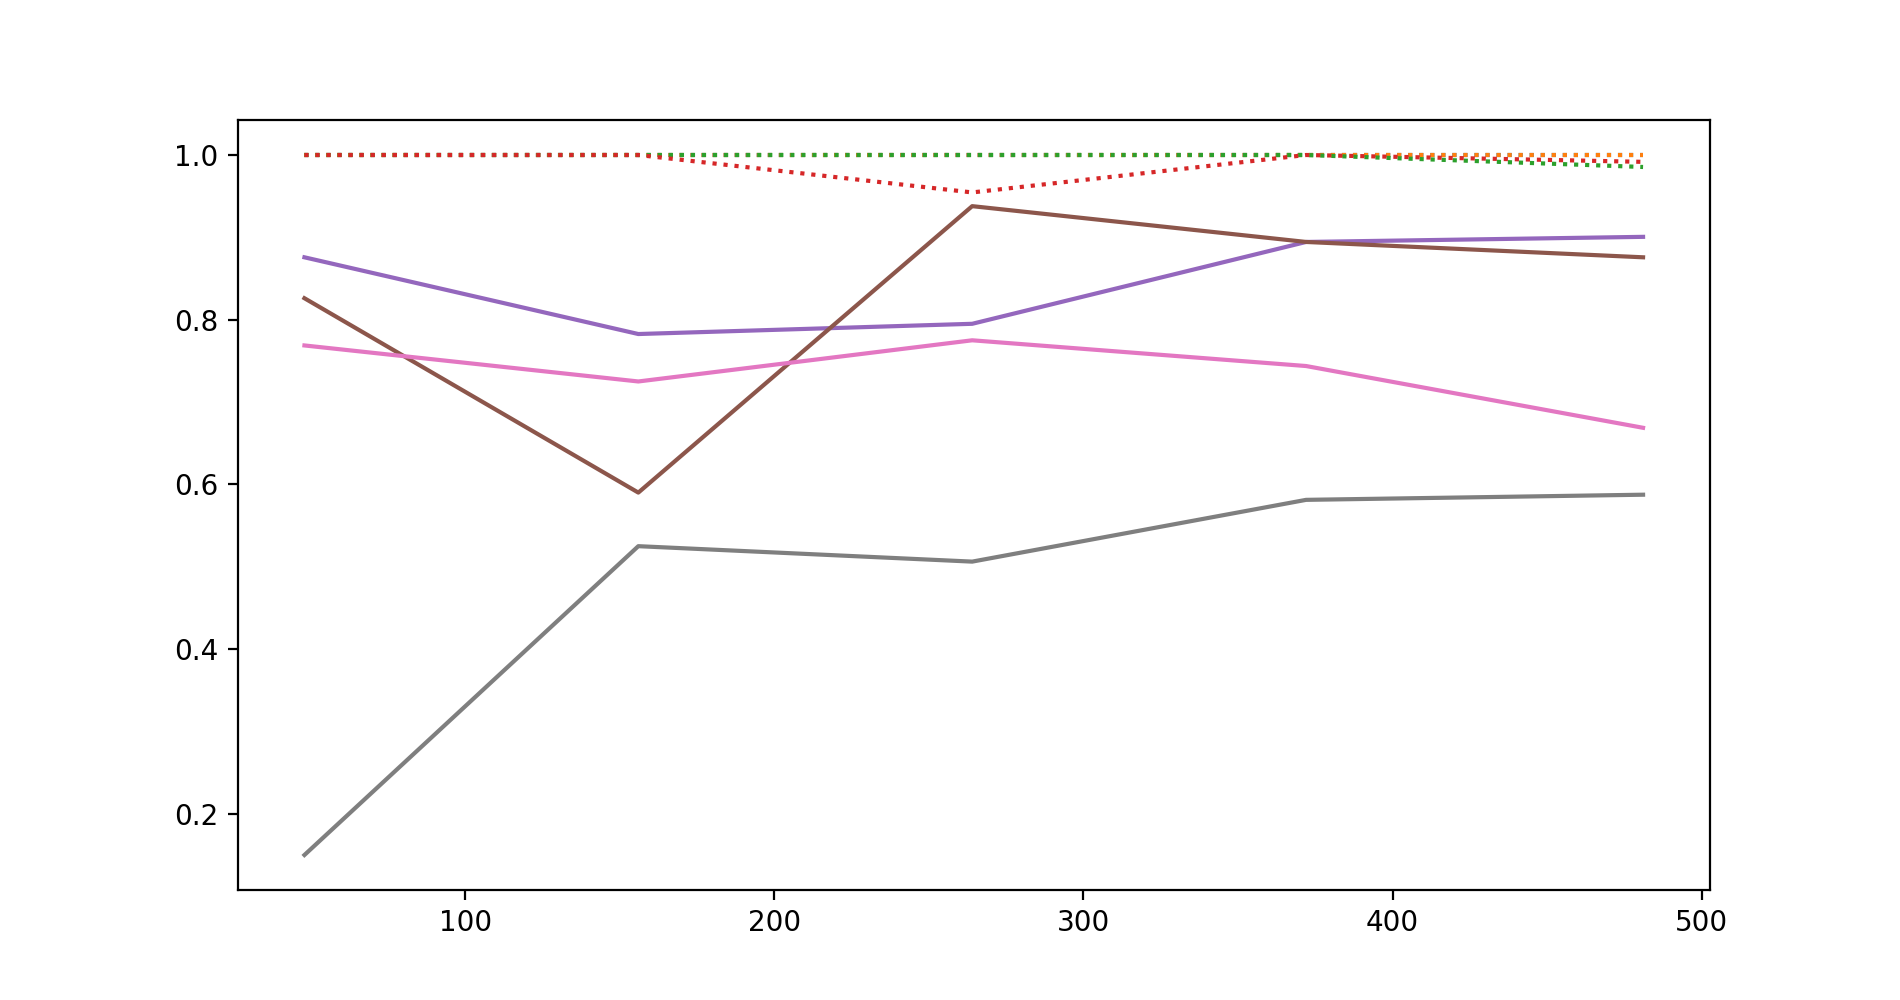

Cross validation: [ 0.92546584  0.89440994  0.6875      0.60625   ]


In [8]:
if 1:
    fig,ax = plt.subplots(figsize=(9.5,5))

    # run for all
    s = sklearn.model_selection.cross_val_score(clf,spectra,labels_onehot,cv=4,verbose=0)
    print('Cross validation:',s)

    # and at different numbers
    sz,train_score,test_score = sklearn.model_selection.learning_curve(clf,spectra,labels_onehot,
                                                                      train_sizes=np.linspace(0.1,1,5),cv=4)
    ax.plot(sz,train_score,':')
    ax.plot(sz,test_score)

In [23]:
# classification report using test set
pred = clf.predict(data_test)
print(sklearn.metrics.classification_report(labels_test_nums, pred,target_names=label_names))

             precision    recall  f1-score   support

    class I       1.00      0.88      0.93        24
   class II       0.84      0.88      0.86        24
 transition       0.86      1.00      0.93        19
     debris       1.00      0.80      0.89        51
       star       0.86      1.00      0.92        49
    be star       0.96      1.00      0.98        26

avg / total       0.93      0.92      0.92       193



<IPython.core.display.Javascript object>


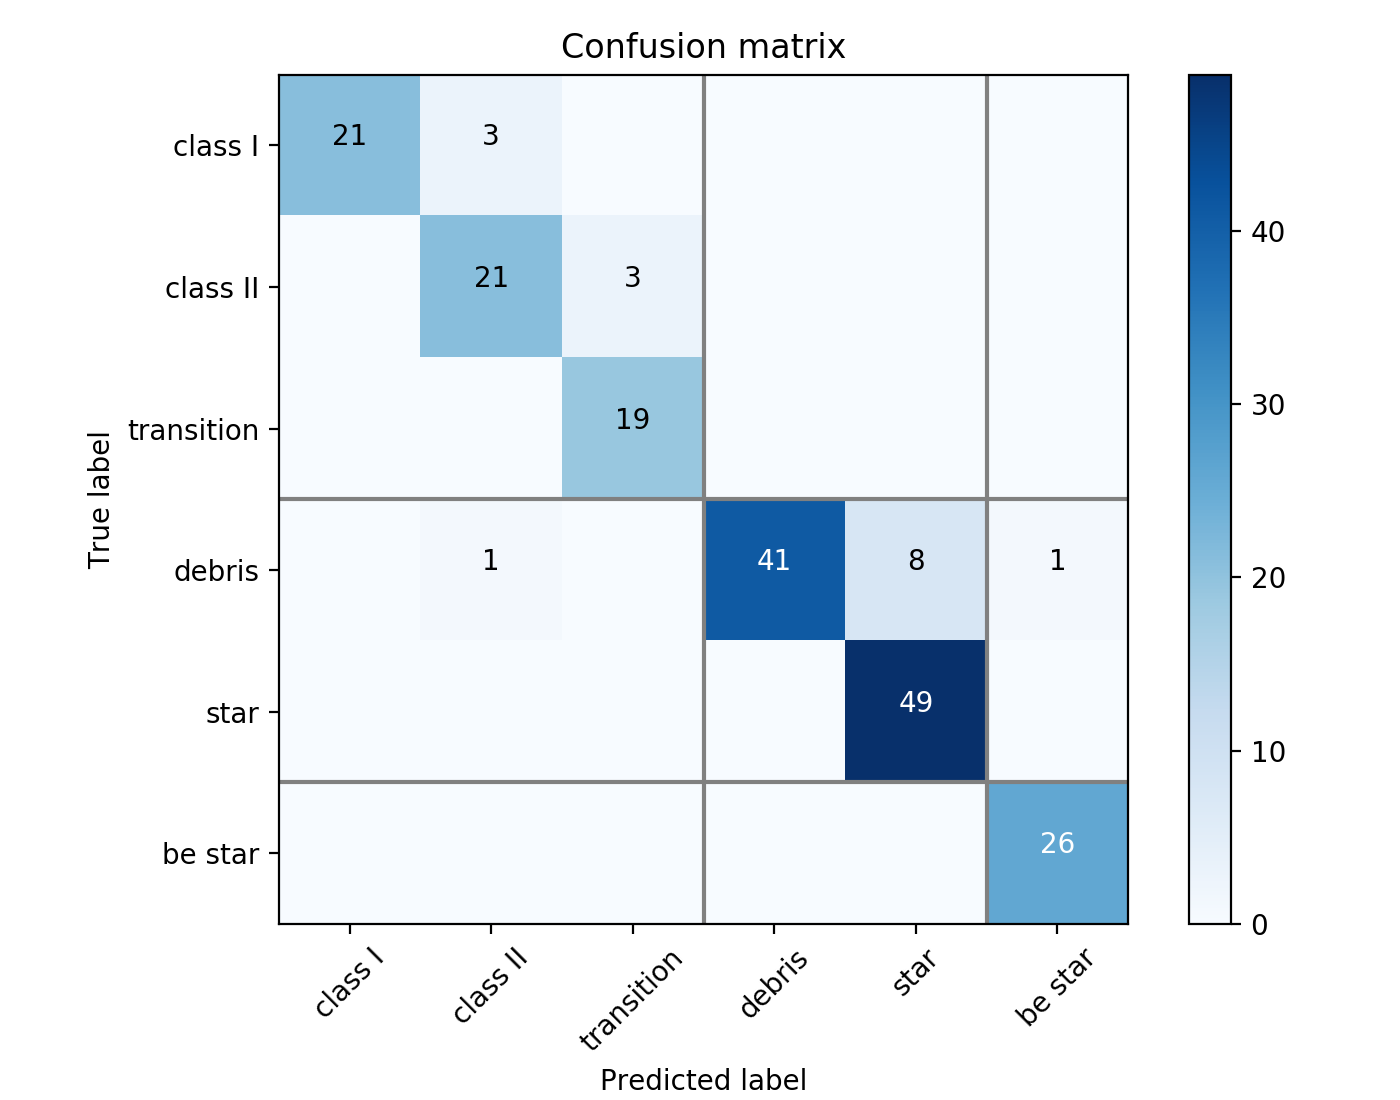

In [24]:
cm = sklearn.metrics.confusion_matrix(labels_test_nums, pred)
plot_confusion_matrix(cm,label_names,lines=[2.5,4.5])

In [25]:
# save the model
with open('../../classifier/irs-nn-classifier.pkl','wb') as f:
    pickle.dump(label_names,f)
    pickle.dump(clf,f)

# Multi-label classification
Similar to above, but now for remaining labels. Ignore spectral types as things are better without.

In [26]:
# get the data
skip = ['class I','class II','transition',
        'debris','star','be star',
       'o-type','b-type','a-type','f-type','g-type',
        'k-type','m-type','brown dwarf',
       'gas abs',
        '[nev]',
        'sl/ll offset'
       ]

spectra,sn,files,label_names,labels_onehot = get_data(label_skip=skip,sn_cut=10,
                                                      median=3)

# and the corresponding wavelength array
_,_,wavelengths = read_spec(cfg.spectra+'training/'+files[0])

spec_len = spectra.shape[1]
nspec = spectra.shape[0]
nlabels = len(label_names)

for i in range(nlabels):
    print(np.sum(labels_onehot[:,i]),label_names[i])

Skipping cassis_yaaar_spcfw_20838656t.fits
Skipping cassis_yaaar_spcfw_4928768t.fits
Skipping cassis_yaaar_spcfw_16008960t.fits
Skipping cassis_yaaar_spcfw_16012288t.fits
Skipping cassis_yaaar_spcfw_21875712t.fits
Skipping cassis_yaaar_spcfw_22806016t.fits
Skipping cassis_yaaar_spcfw_18768128t.fits
Skipping cassis_yaaar_spcfw_18824704t.fits
Skipping cassis_yaaar_spcfw_18836992t.fits
Skipping cassis_yaaar_spcfw_20814336t.fits
Skipping cassis_yaaar_spcfw_20818432t.fits
Skipping cassis_yaaar_spcfw_20830464t.fits
82.0 am sil em
18.0 cryst sil em
9.0 pah em
18.0 gas em
41.0 am sil abs
40.0 ice abs


<IPython.core.display.Javascript object>


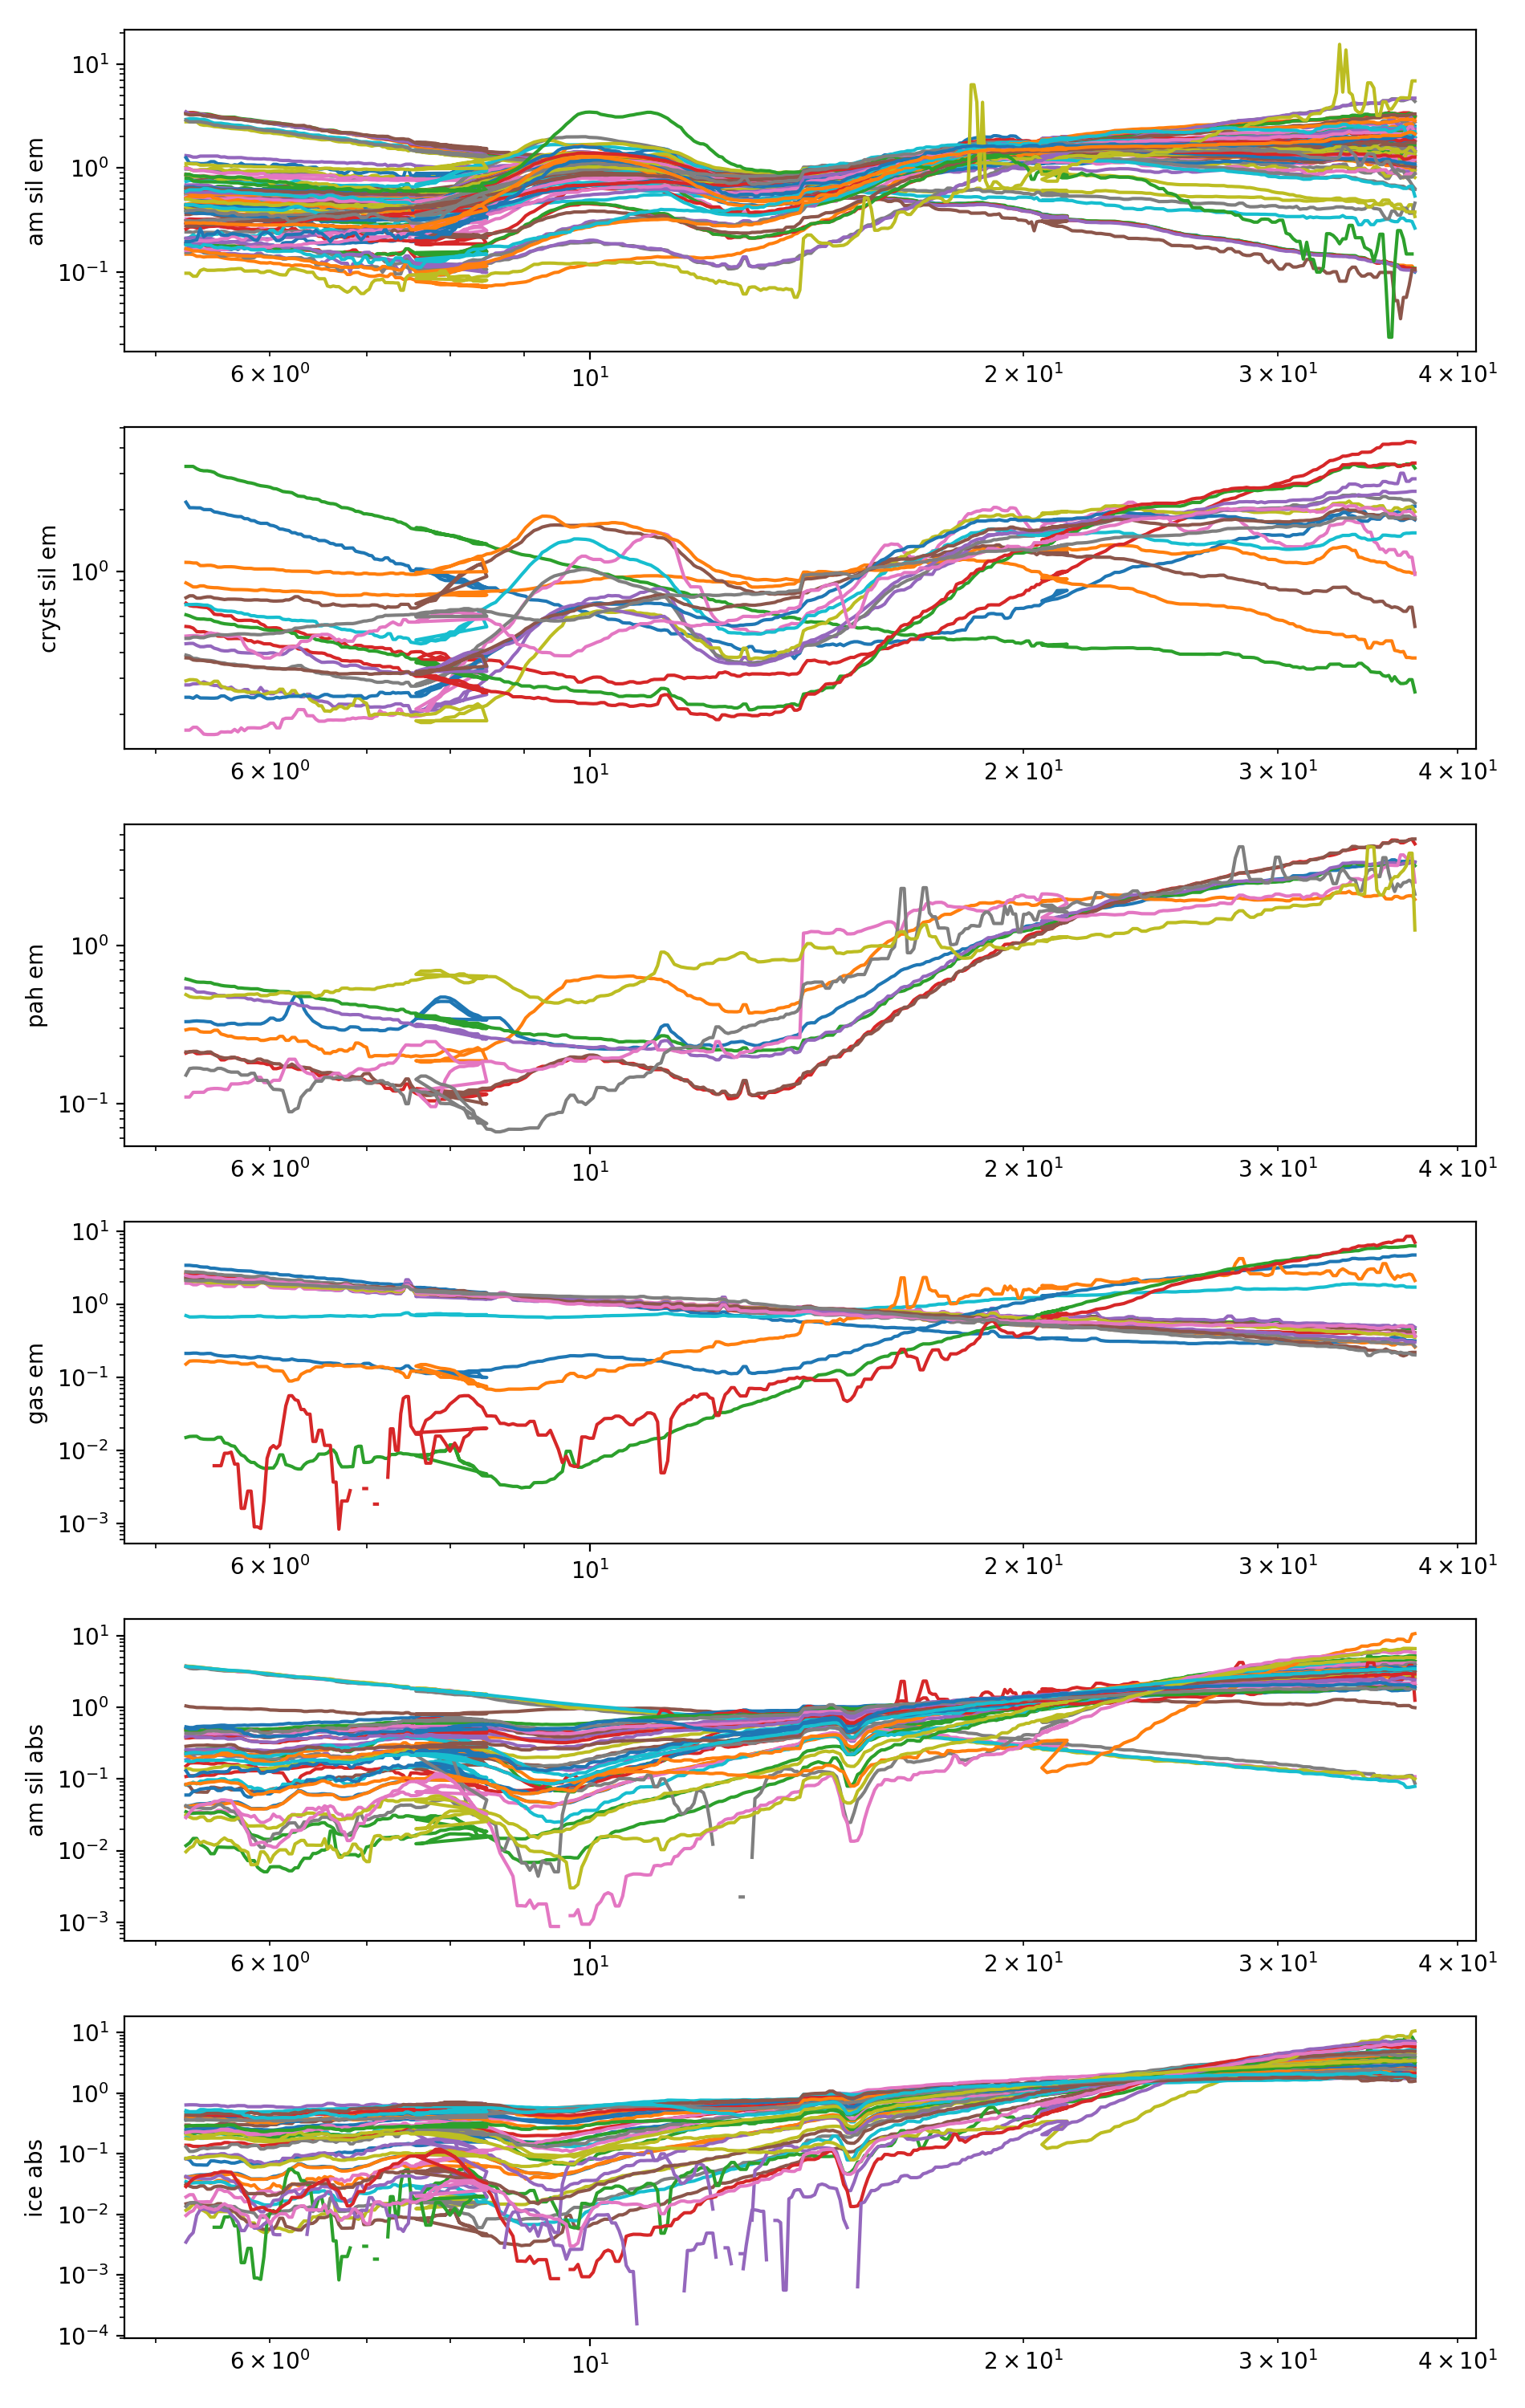

In [27]:
fig,ax = plt.subplots(nlabels,figsize=(9.5,15))
for i in range(nlabels):
    ok = labels_onehot[:,i] == 1
    l = ax[i].loglog(wavelengths,spectra[ok].T)
    ax[i].set_ylabel(label_names[i])
    
fig.tight_layout()

In [43]:
data_train,labels_train,data_test,labels_test = split_data(spectra,labels_onehot,train_fraction=0.5)

In [44]:
# this sets the defaults for things not varied in the grid search
if 0:
    clf = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(10,20,10),
                       tol=1e-6, warm_start=False, max_iter=10000,
                        learning_rate_init=0.001, learning_rate='adaptive')

    grid = [#{'solver':['adam'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
#              'alpha':[1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
#              {'solver':['sgd'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
#               'alpha':[1e-6,1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
            {'solver':['lbfgs'], 'hidden_layer_sizes':[(40,80,40),(20,40,20),(10,20,10)],
             'alpha':[1e-4,1e-2]}]
    gs = sklearn.model_selection.GridSearchCV(clf,grid,cv=4)
    gs.fit(data_train,labels_train)

    print("Best parameters found on training set:")
    print(gs.best_params_)
    print()
    print("Grid scores on training set:")
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

In [45]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(20,40,20),
                   tol=1e-6, warm_start=False, max_iter=5000,
                    learning_rate_init=0.001, learning_rate='adaptive')

clf.fit(data_train,labels_train)
print('Step',clf.n_iter_,'loss',clf.loss_)

Step 1701 loss 0.00302058992243


In [46]:
if 0:
    fig,ax = plt.subplots(figsize=(9.5,5))

    # run for all
    s = sklearn.model_selection.cross_val_score(clf,spectra,labels_onehot,cv=4,verbose=0)
    print('Cross validation:',s)

    # and at different numbers
    sz,train_score,test_score = sklearn.model_selection.learning_curve(clf,spectra,labels_onehot,
                                                                      train_sizes=np.linspace(0.1,1,5),cv=4)
    ax.plot(sz,train_score,':')
    ax.plot(sz,test_score)

In [47]:
# classification report using test set
pred = clf.predict(data_test)
print(sklearn.metrics.classification_report(labels_test, pred,target_names=label_names))

              precision    recall  f1-score   support

   am sil em       0.81      0.96      0.88        26
cryst sil em       1.00      0.29      0.44         7
      pah em       1.00      0.20      0.33         5
      gas em       0.50      0.50      0.50         4
  am sil abs       0.73      0.80      0.76        10
     ice abs       0.80      1.00      0.89         8

 avg / total       0.81      0.77      0.74        60



<IPython.core.display.Javascript object>


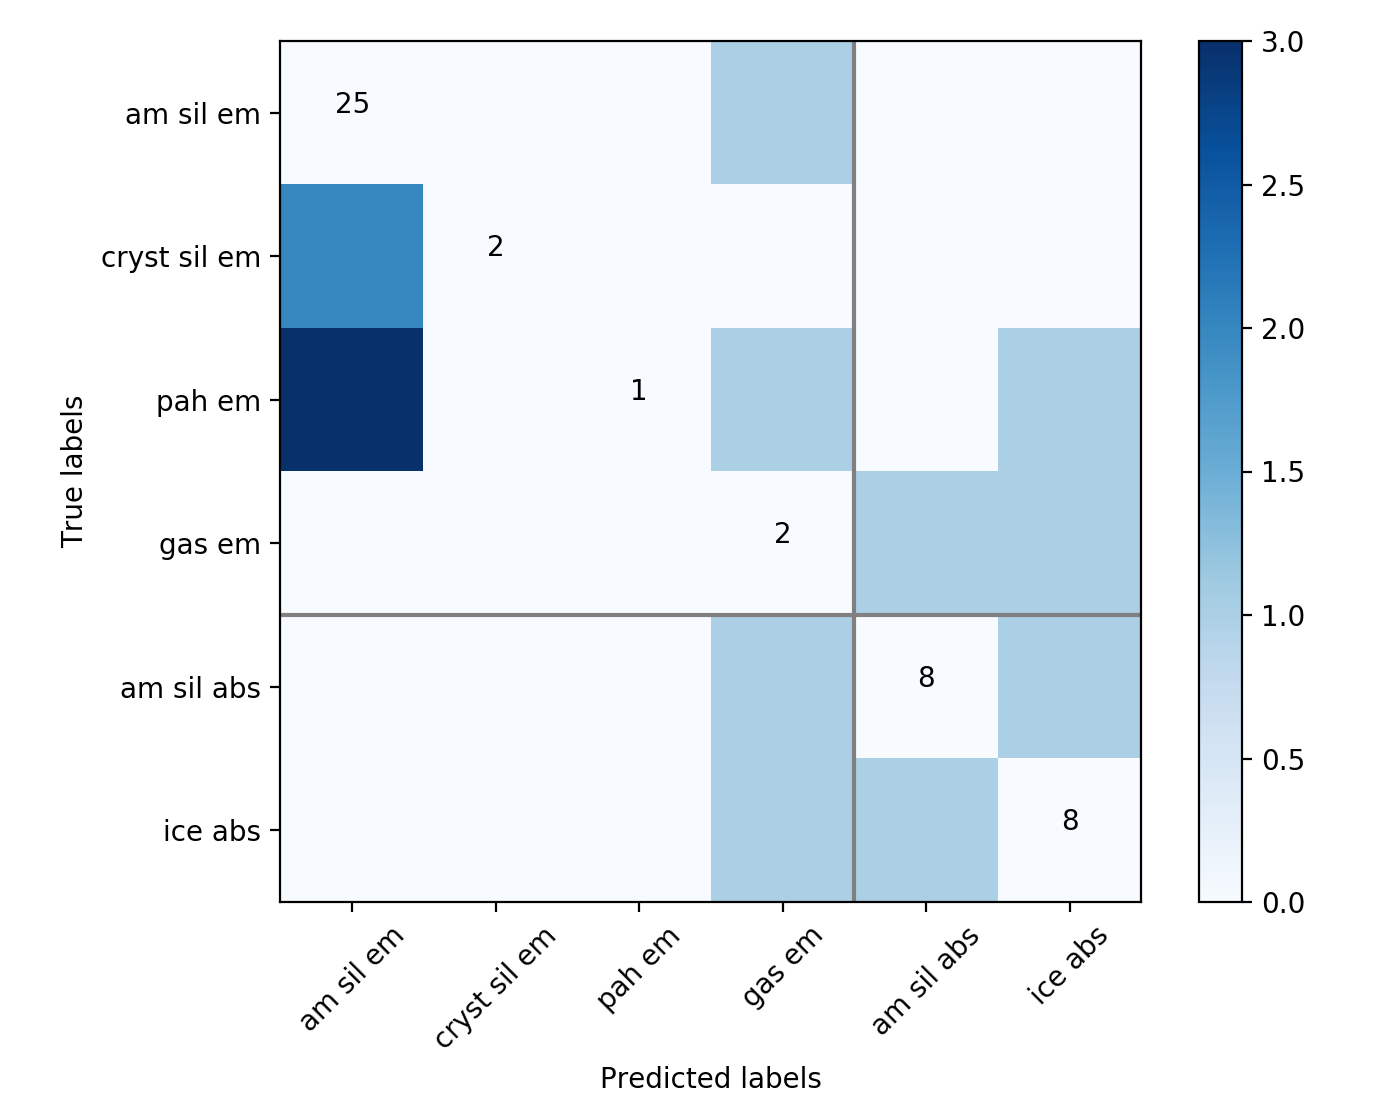

In [48]:
plot_multilabel_confusion_matrix(labels_test,pred,label_names,lines=[3.5])

In [68]:
# save the model
with open('../../classifier/irs-nn-labeller.pkl','wb') as f:
    pickle.dump(label_names,f)
    pickle.dump(clf,f)

# test the model

Now test the model against some other spectra, see what it thinks they are, and see if we agree. First the test set, and then some random spectra

<IPython.core.display.Javascript object>


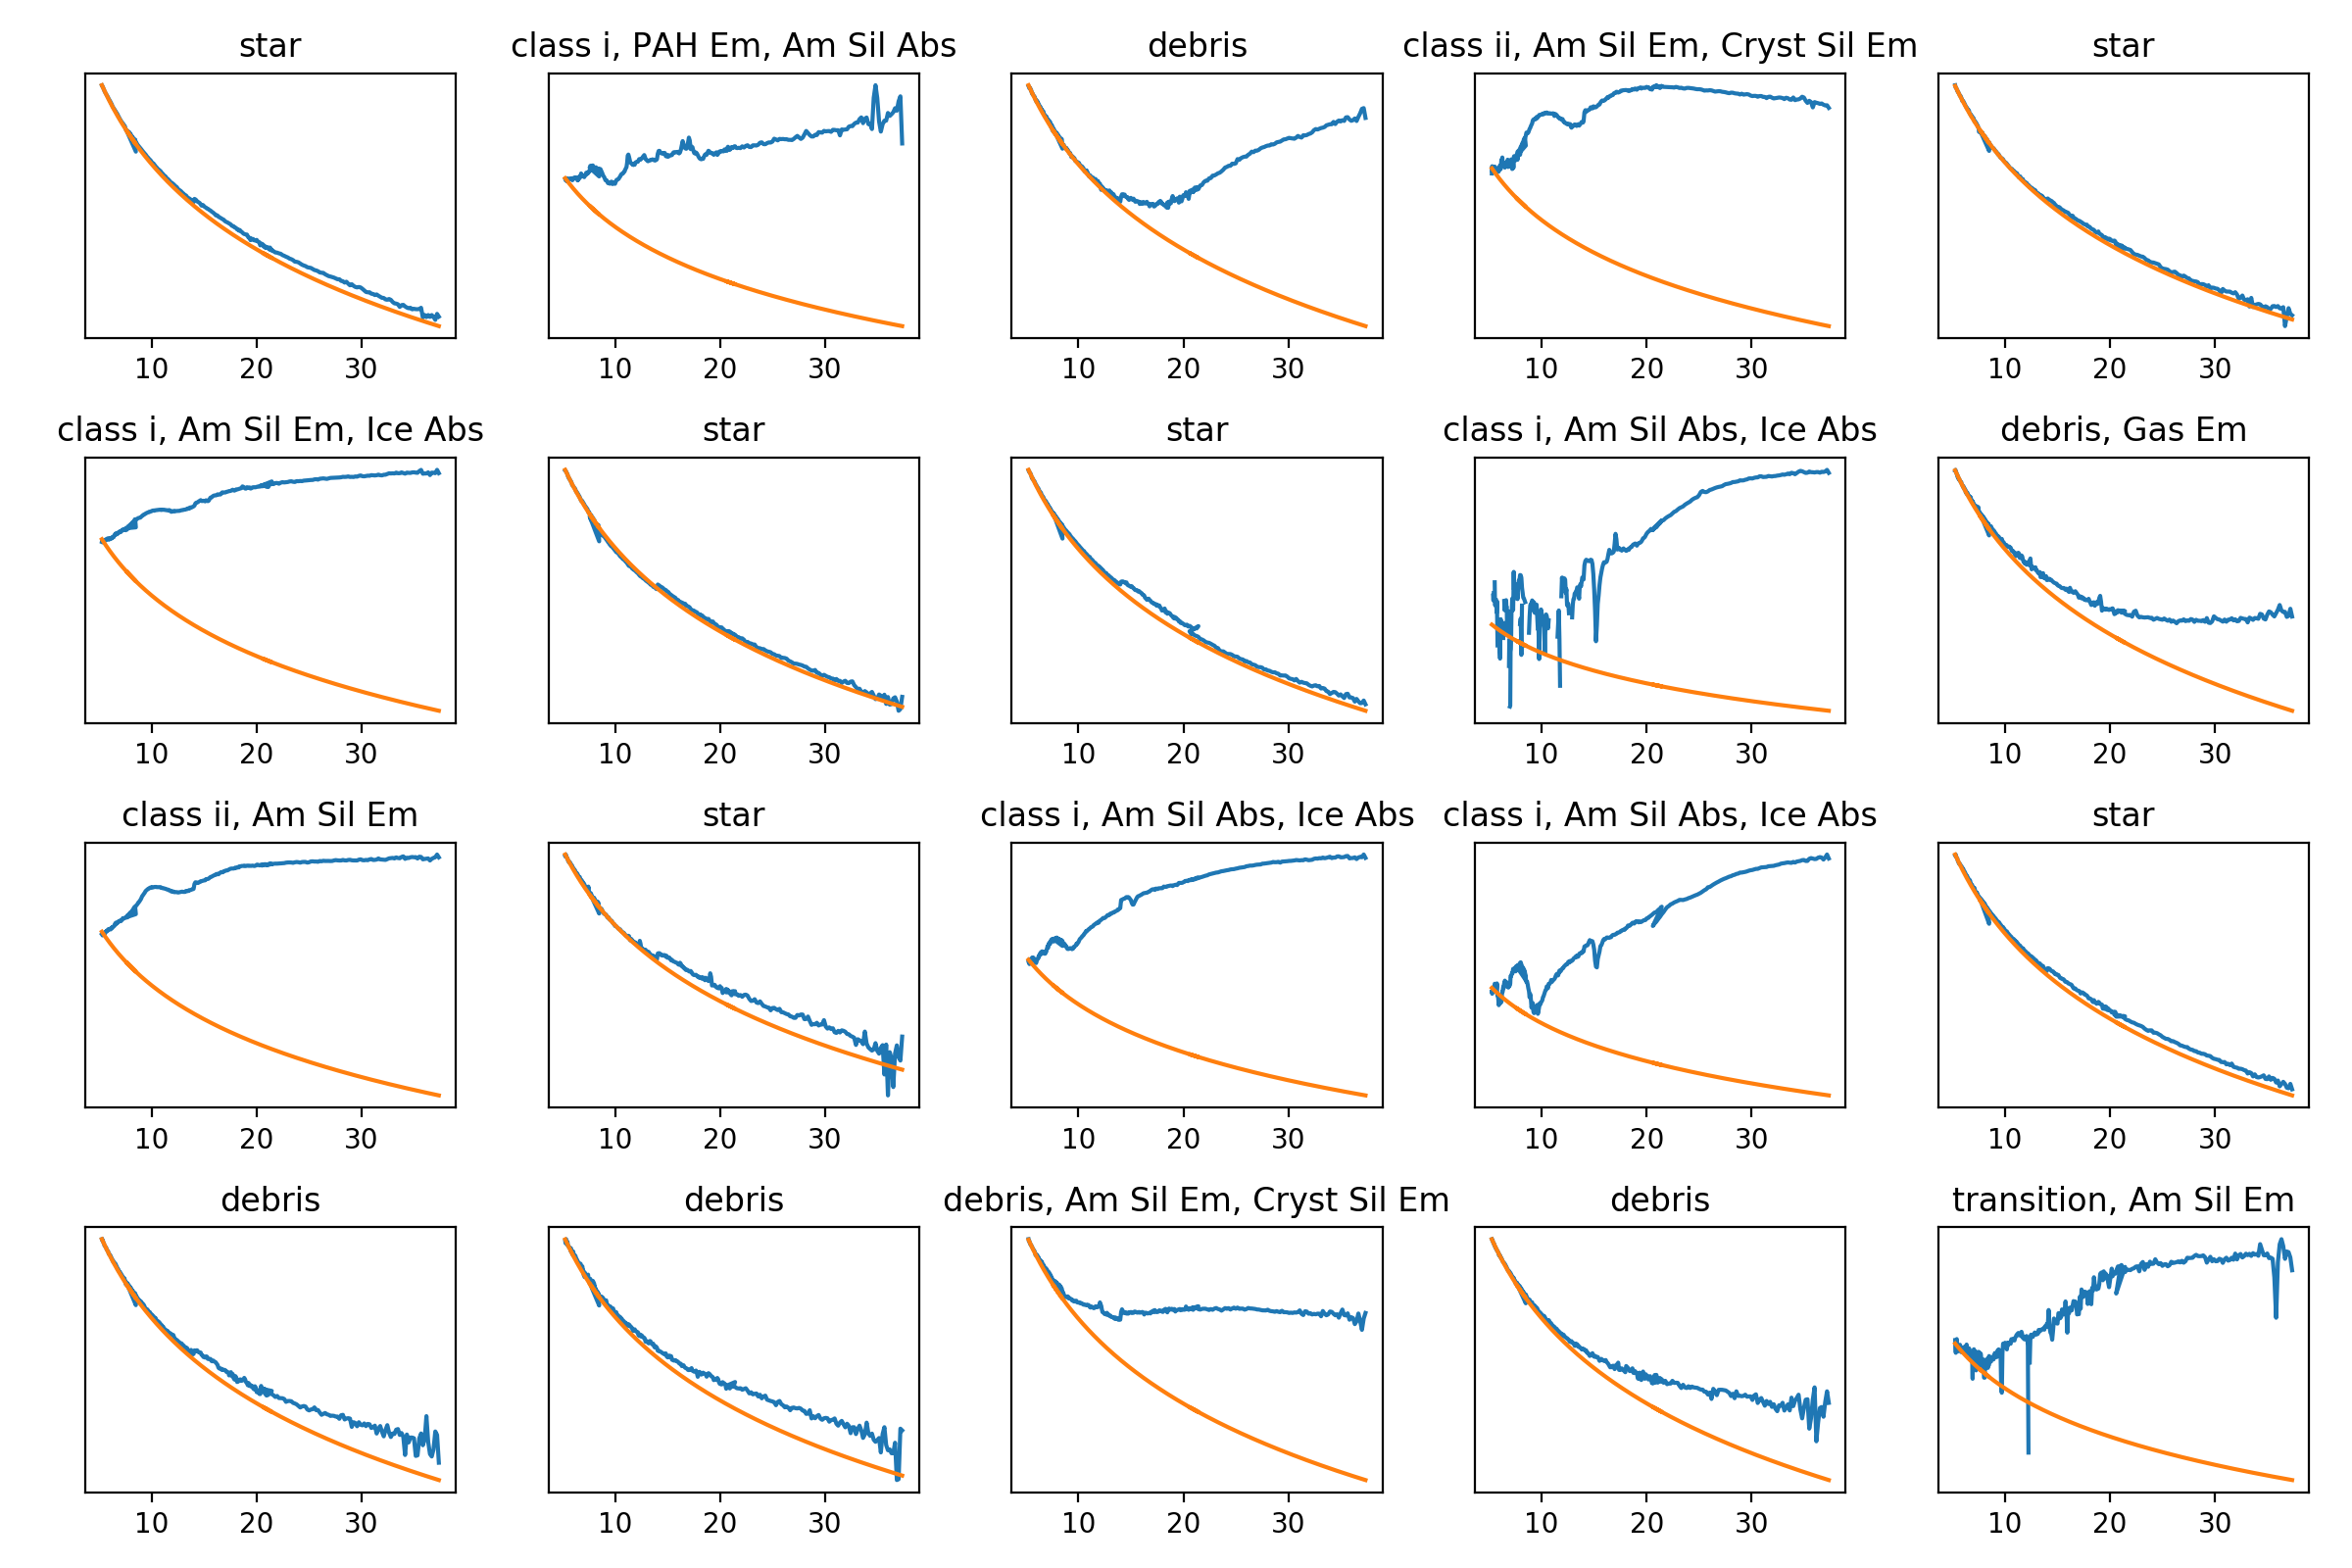

In [70]:
fs = glob.glob(cfg.spectra+'irsstare/*.fits')
spec_grid = (4,5)
nspec = spec_grid[0] * spec_grid[1]
fig,ax = plt.subplots(spec_grid[0],spec_grid[1],figsize=(12,8))
i = 0
while i < nspec:
    j = np.random.randint(len(fs))
    spec = read_spec(fs[j],norm=False)
    spec_norm = read_spec(fs[j])
    if spec is None:
        continue
    else:
        spec,sn,wavelengths = spec
    axi = np.unravel_index(i,spec_grid)
    ax[axi].semilogy(wavelengths,spec)
    ax[axi].plot(wavelengths,wavelengths**(-2)*np.mean(spec[:10])/np.mean(wavelengths[:10]**(-2)))

    pred = predict_spectra_class(fs[j])
    pred1 = predict_spectra_labels(fs[j])
    
    lab = np.append(pred,pred1)
    ax[axi].set_title(', '.join(lab))
    ax[axi].get_yaxis().set_visible(False)
    i += 1
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

# Extras

## Keras version similar to above, more flexibility in building neural network

In [41]:
model = Sequential()

# model.add(Dense(100, input_dim=spec_len))
# model.add(Activation('relu'))

model.add(Conv1D(10,10,strides=2,input_shape=(spec_len,1)))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dense(nlabels))
model.add(Activation('sigmoid'))

def loss(y_true, y_pred):
    '''Binary log loss, from sklearn/neural_network/_base.py'''
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=True)
opt = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])

data_in = data_train.reshape(data_train.shape[0],data_train.shape[1],1)
model.fit(data_in, labels_train, epochs=5000, batch_size=50)

Epoch 1/5000
249/249 [==============================] - 0s - loss: 0.6248 - acc: 0.0281         
Epoch 2/5000
249/249 [==============================] - 0s - loss: 0.3842 - acc: 0.3253     
Epoch 3/5000
249/249 [==============================] - 0s - loss: 0.2983 - acc: 0.3896     
Epoch 4/5000
249/249 [==============================] - 0s - loss: 0.2494 - acc: 0.3253     
Epoch 5/5000
249/249 [==============================] - 0s - loss: 0.2268 - acc: 0.4578     
Epoch 6/5000
249/249 [==============================] - 0s - loss: 0.2081 - acc: 0.5663     

In [42]:
# tmp = model.predict(data_test)
tmp = model.predict(data_test.reshape(data_test.shape[0],data_test.shape[1],1))
pred = np.zeros(tmp.shape)
pred[tmp>0.5] = 1 
print(sklearn.metrics.classification_report(labels_test, pred, target_names=label_names))

              precision    recall  f1-score   support

     Class I       1.00      1.00      1.00         6
    Class II       0.90      1.00      0.95        18
  Transition       0.00      0.00      0.00         1
      Kuiper       0.80      0.73      0.76        33
    Exo-Zodi       0.67      0.50      0.57         4
        Star       0.82      0.84      0.83        43
      O-type       0.00      0.00      0.00         1
      B-type       0.25      0.50      0.33         4
      A-type       0.90      0.69      0.78        26
      F-type       0.17      0.10      0.12        10
      G-type       0.17      0.11      0.13         9
      K-type       0.40      0.29      0.33         7
      M-type       0.00      0.00      0.00         1
 Brown Dwarf       0.00      0.00      0.00         0
   Am Sil Em       1.00      0.83      0.91        24
Cryst Sil Em       0.67      0.33      0.44         6
      PAH Em       0.00      0.00      0.00         0
       Be Em       1.00    

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


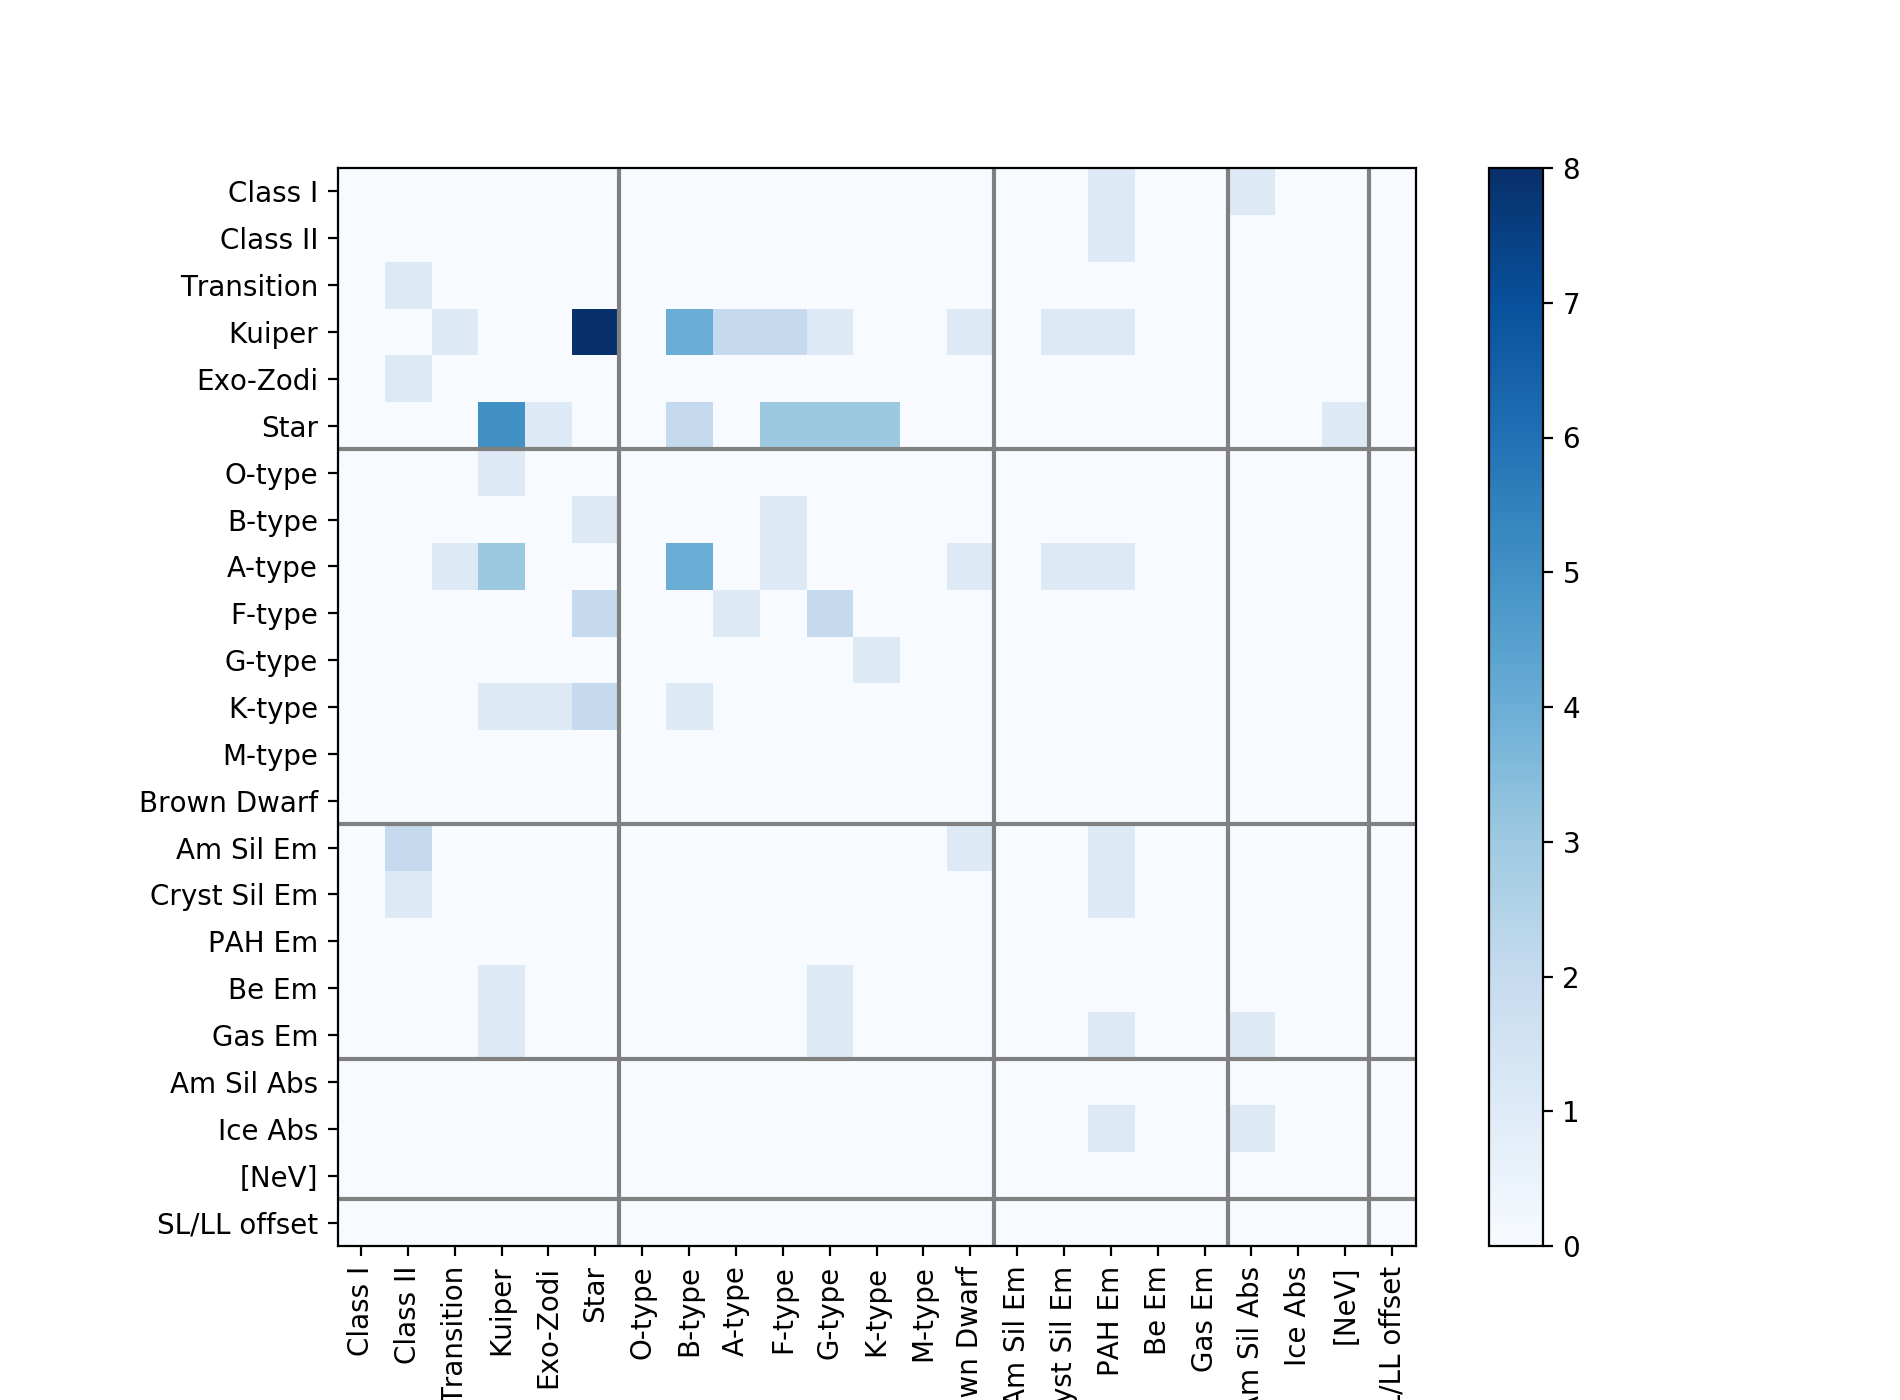

In [43]:
plot_multilabel_confusion_matrix(labels_test,pred,label_names)

<IPython.core.display.Javascript object>


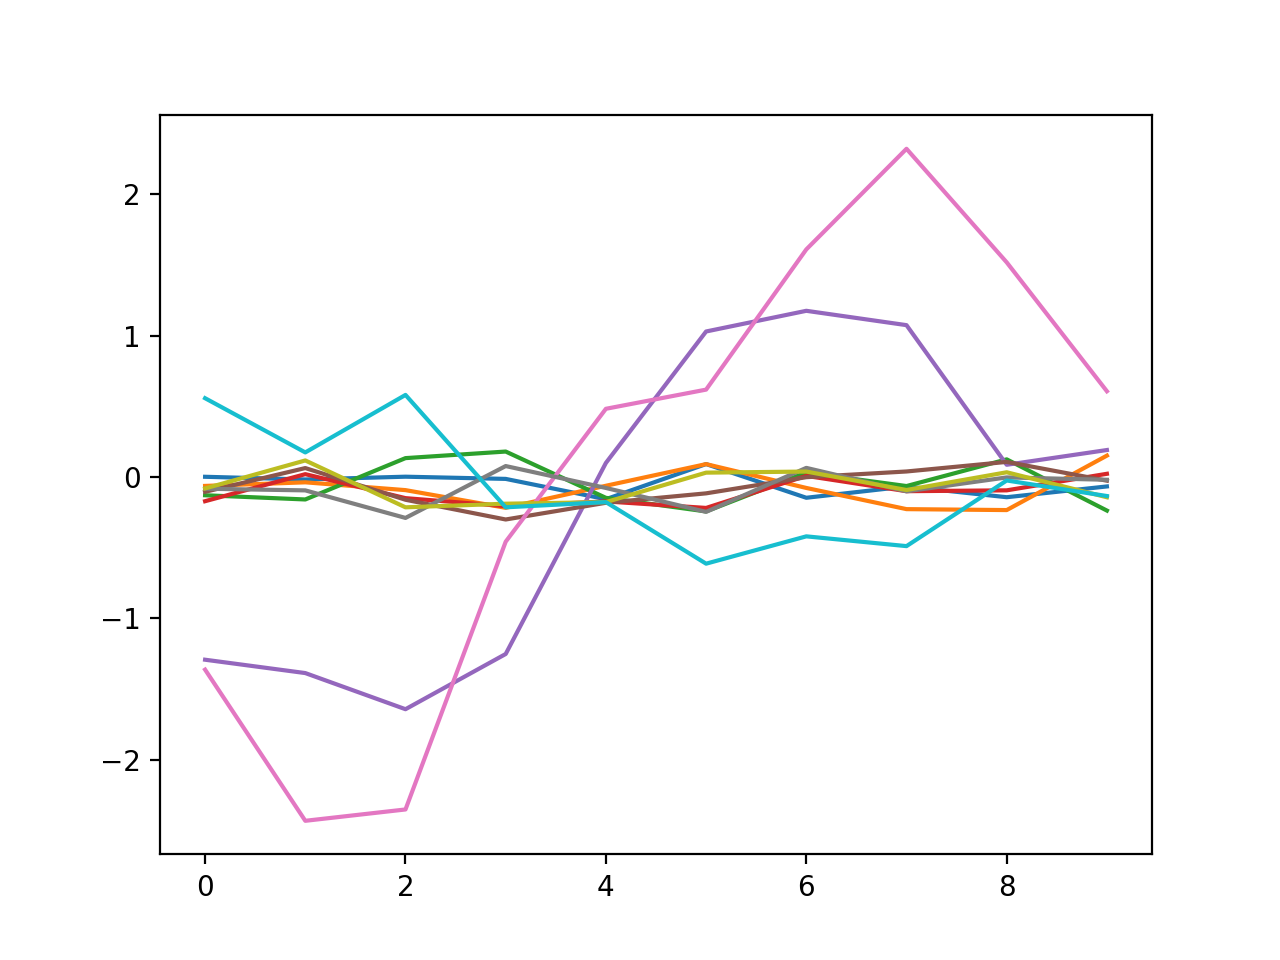

In [44]:
l = model.get_layer(index=1).get_weights()
fig,ax = plt.subplots()
ax.plot(l[0][:,0,:])